In [2]:
from datetime import datetime, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Constants
INPUT_DATA_PATH = "/kaggle/input/ashrae-energy-prediction"

MIN_TRAIN_TIMESTAMP = pd.Timestamp("2016-01-01 00:00:00")
MAX_TRAIN_TIMESTAMP = pd.Timestamp("2016-12-31 23:00:00")
TRAIN_DATA_RESOLUTION = "1h"

In [4]:
# Load meter readings
readings_df = pd.read_csv(
    f"{INPUT_DATA_PATH}/train.csv",
    header=0,
    names=["building_id", "meter_id", "timestamp", "meter_reading"],
)
readings_df["timestamp"] = pd.to_datetime(readings_df["timestamp"])
readings_df["ln_meter_reading"] = np.log1p(readings_df["meter_reading"])

## Electricity Readings

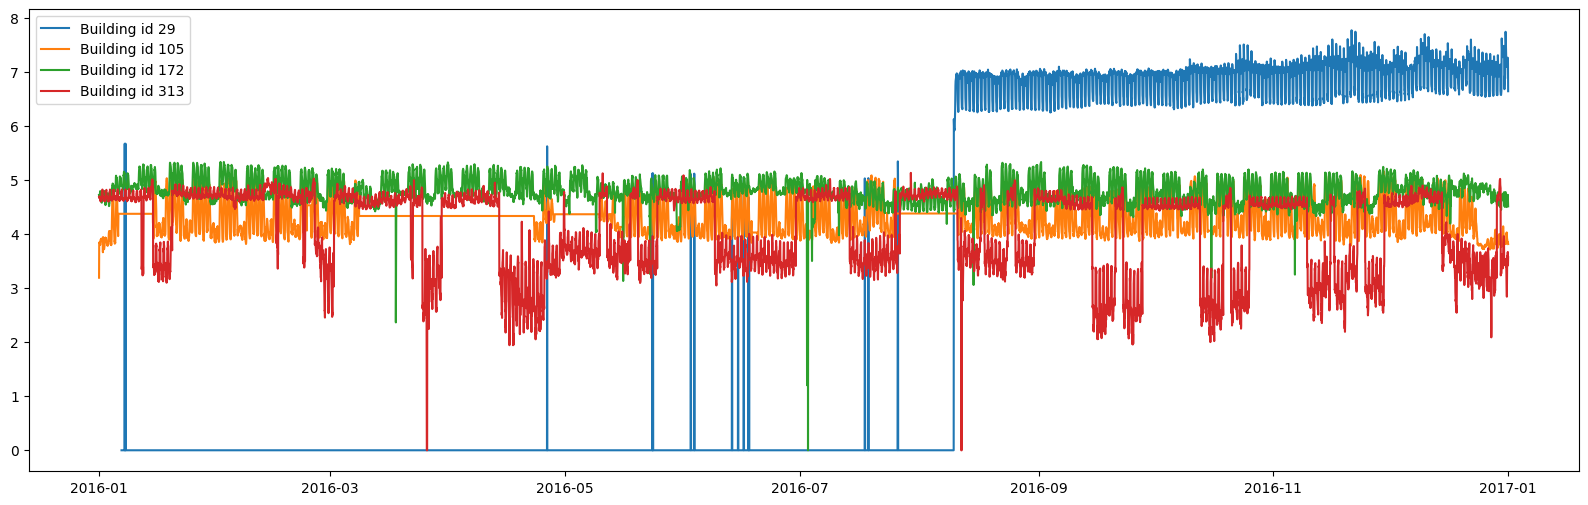

In [54]:
# meter_id: type -> {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

meter_id = 0
building_ids = [29, 105, 172, 313]

df = readings_df[(readings_df["building_id"].isin(building_ids)) & (readings_df["meter_id"] == meter_id)]

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
for b_id in building_ids:
    b_df = df[df["building_id"] == b_id]
    ax.plot(
        b_df["timestamp"].values,
        b_df["ln_meter_reading"].values,
        label=f"Building id {b_id}",
    )

ax.legend()

### Filter on timestamps

In [5]:
def construct_keep_filter(
    timestamps: pd.Series,
    to_keep: list[tuple[datetime | None, datetime | None]],
):
    filter_ = False 
    for start, end in to_keep:
    
        match (start, end):
            case None, None:
                pass
            case (datetime(), None):
                period_filter = timestamps >= start
            case (None, datetime()):
                period_filter = timestamps <= end
            case (datetime(), datetime()):
                period_filter = (timestamps >= start) & (timestamps <= end)
        
        filter_ |= period_filter
    
    return filter_


def to_keep_filter(
    data: pd.DataFrame,
    to_keep: list[tuple[datetime | None, datetime | None]]
):
    keep_filter = construct_keep_filter(data["timestamp"], to_keep)
    return data.loc[keep_filter]

In [6]:
def find_constant_streaks(
    df: pd.DataFrame,
    streak_length: int = 10,
    target_column: str = "ln_meter_reading"
):
    # Compute diffs on target col
    df = df.copy()
    df = df.sort_values("timestamp")
    df["target_col_diff"] = df[target_column].diff()
    
    # First find any periods of constant meter readings
    streaks = []
    current_streak_start = 0
    for idx, row in df.iterrows():
        if pd.isna(row["target_col_diff"]):
            continue
        
        elif row["target_col_diff"] == 0:
            # Start a new streak if not already a running streak
            current_streak_start = current_streak_start or idx - 1
        
        else:
            # Streak finished
            # Save if there is currently a running streak
            if current_streak_start is not None:
                streaks.append((current_streak_start, idx - 1))
    
            # Reset
            current_streak_start = None
            

    # Only keep streaks with length >= streak_length
    filtered_streaks = []
    for start, end in streaks:
        streak_df = df.loc[start: end]
        assert (streak_df["target_col_diff"].dropna() == 0).all(), print(start, end)
        if len(streak_df) >= streak_length:
            start_t = streak_df["timestamp"].min().to_pydatetime()
            end_t = streak_df["timestamp"].max().to_pydatetime()
            filtered_streaks.append((start_t, end_t))
    
    return filtered_streaks

In [7]:
# Apply to all electricity data

def filter_electricity_data(
    readings_df: pd.DataFrame,
    to_keep_filters: dict[int, list[tuple[datetime | None, datetime | None]]],
):
    meter_id = 0
    for b_id, b_filter in tqdm(to_keep_filters.items()):
        bm_df = readings_df[
            (readings_df["building_id"] == b_id)
            & (readings_df["meter_id"] == meter_id)
        ]
        bm_df_filtered = to_keep_filter(bm_df, b_filter)
        readings_df = readings_df.drop(bm_df.index)
        readings_df = pd.concat([readings_df, bm_df_filtered], axis=0)
    return readings_df

In [ ]:
readings_before = readings_df.copy()
readings_after = filter_electricity_data(readings_df, to_keep_electricity)

## Chilled Water

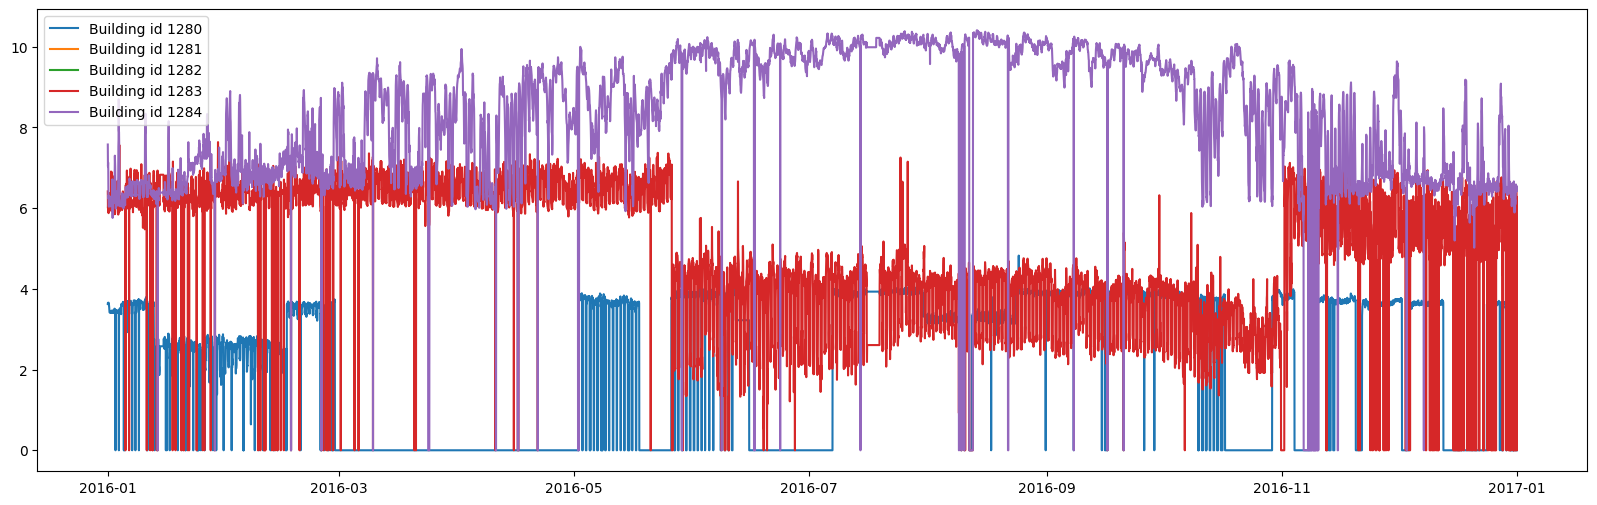

In [237]:
# meter_id: type -> {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

meter_id = 1
start_id = 1280
building_ids = list(range(start_id, start_id + 5))
# building_ids = [273, 282]

df = readings_df[(readings_df["building_id"].isin(building_ids)) & (readings_df["meter_id"] == meter_id)]

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
for b_id in building_ids:
    b_df = df[df["building_id"] == b_id]
    ax.plot(
        b_df["timestamp"].values,
        b_df["ln_meter_reading"].values,
        label=f"Building id {b_id}",
    )

ax.legend()

In [241]:
# sorted(readings_df[readings_df["meter_id"] == 1]["building_id"].unique())[350:]

2016-01-01 01:00:00 2016-01-13 12:00:00
2016-01-14 01:00:00 2016-01-28 18:00:00
2016-01-28 22:00:00 2016-01-31 18:00:00
2016-02-01 23:00:00 2016-02-20 15:00:00
2016-02-21 04:00:00 2016-02-25 11:00:00
2016-02-25 14:00:00 2016-02-28 16:00:00
2016-03-02 06:00:00 2016-03-07 16:00:00
2016-03-14 00:00:00 2016-03-15 16:00:00
2016-03-19 02:00:00 2016-03-22 17:00:00
2016-07-16 06:00:00 2016-07-19 10:00:00
2016-10-22 07:00:00 2016-10-23 15:00:00
2016-11-12 00:00:00 2016-11-13 17:00:00
2016-11-13 23:00:00 2016-11-15 16:00:00
2016-11-19 22:00:00 2016-11-24 17:00:00
2016-11-26 00:00:00 2016-11-30 04:00:00
2016-12-01 10:00:00 2016-12-03 07:00:00
2016-12-03 10:00:00 2016-12-12 19:00:00
2016-12-13 00:00:00 2016-12-18 12:00:00
2016-12-18 22:00:00 2016-12-22 18:00:00
2016-12-22 23:00:00 2016-12-27 16:00:00


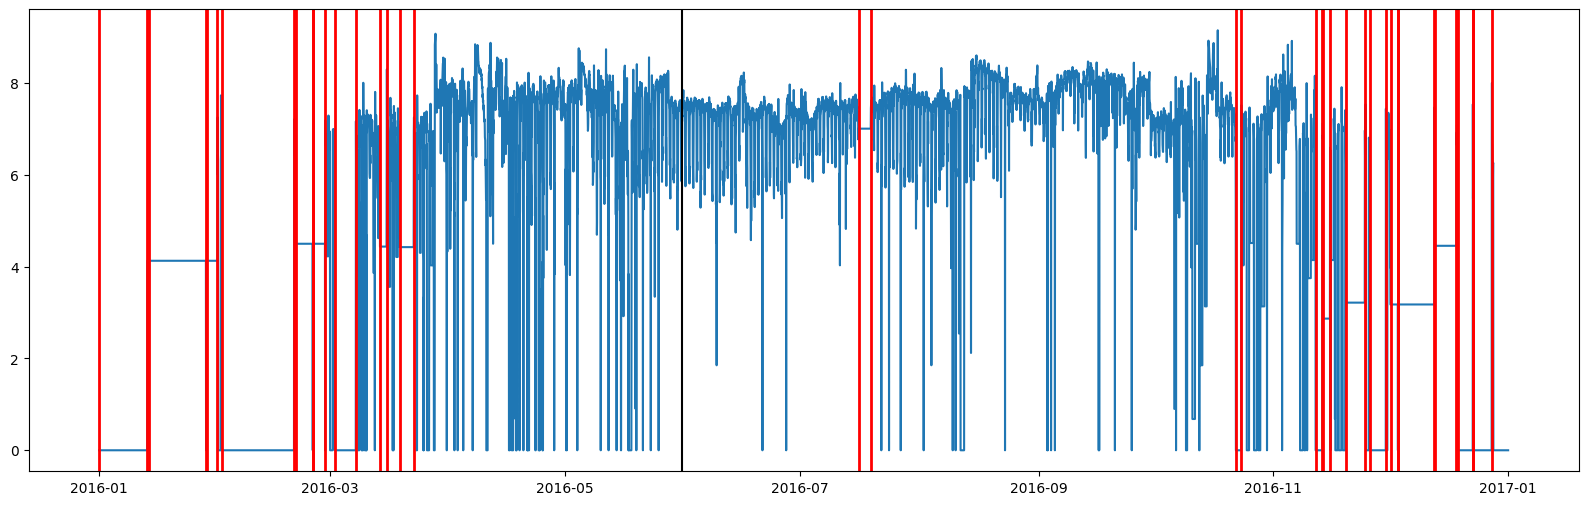

In [236]:
# meter_id: type -> {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

meter_id = 1
building_id = 1275

bm_df = readings_df[(readings_df["building_id"] == building_id) & (readings_df["meter_id"] == meter_id)]
streaks = find_constant_streaks(bm_df, streak_length=25)

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.plot(
    bm_df["timestamp"].values,
    bm_df["ln_meter_reading"].values,
)

for start, end in streaks:
    print(start, end)
    ax.axvline(start, lw=2, color="red")
    ax.axvline(end, lw=2, color="red")

ax.axvline(datetime(2016, 5, 31, 12), color="black")
# 2016-05-31 16:00:00 2016-06-16 23:00:00

In [244]:
to_keep = {
    60: [(datetime(2016, 4, 29, 10, 0), None)],
    161: [(datetime(2016, 1, 4, 4, 0), None)],
    192: [(None, datetime(2016, 5, 9, 13))],
    195: [(None, datetime(2016, 3, 17, 12)), (datetime(2016, 3, 22), None)],
    236: [(None, datetime(2016, 1, 24, 2)), (datetime(2016, 3, 21, 12), None)],
    259: [(datetime(2016, 4, 8), None),],
    264: [(datetime(2016, 2, 8, 10), None)],
    747: [(datetime(2016, 4, 16, 12), None)],
    765: [(datetime(2016, 4, 22, 12), None)],
    774: [(datetime(2016, 3, 8), None)],
    777: [(datetime(2016, 4, 18, 8), None)],
    778: [(datetime(2016, 9, 8, 9), datetime(2016, 10, 20,))],
    780: [(None, datetime(2016, 8, 2))],
    # 793: [(datetime(2016, 5, 6, 12), datetime(2016, 11, 4, 12)]
    910: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    920: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    923: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    926: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    927: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    929: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    931: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    934: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    954: [(datetime(2016, 8, 8, 10), None)],
    955: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    961: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    963: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    965: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    967: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    969: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    973: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    976: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    989: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    990: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    993: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    994: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    996: [(None, datetime(2016, 7, 1, 16)), (datetime(2016, 7, 5, 4), datetime(2016, 10, 15)), (datetime(2016, 10, 17, 6), None)],
    1167: [(None, datetime(2016, 5, 18, 16)), (datetime(2016, 6, 25, 7), None)],
    1225: [(None, datetime(2016, 8, 23, 12)), (datetime(2016, 10, 11, 13), None)],
    1226: [(None, datetime(2016, 8, 23, 12)), (datetime(2016, 10, 20, 12), None)],
    1244: [(None, datetime(2016, 7, 13, 16)), (datetime(2016, 8, 31, 19), None)],
    1246: [(datetime(2016, 3, 2, 19), None)],
    1272: [(None, datetime(2016, 9, 28, 9)), (datetime(2016, 10, 20, 12), None)],
    1273: [(None, datetime(2016, 5, 31, 16)), (datetime(2016, 6, 16, 23), None)],
    
}

constant_streak_ids = (
    [7,43,75,97,98,162,163,167,171,172,177,188,190,191,195,]
    + [200,207,231,233,235,258,260,265,267,290,747,748,750,751,752,753,755,763,765,770,774,]
    + [776, 777,786, 787, 789, 790, 792, 801, 874, 880, 890, 893, 894, 895, 896, 898, 899, ]
    + [911, 915, 916, 917, 918, 927, 929, 932, 933, 935, 942, 951, 952, 953, 957, 958, 959 ]
    + [960, 961, 962, 964, 965, 966, 968, 971, 972, 974, 975, 978, 979, 980, 981, 983, 987 ]
    + [991, 992, 994, 995, 997, 1223, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233 ]
    + [1234, 1235, 1236, 1238, 1239, 1240, 1241, 1242, 1243, 1246, 1247, 1248, 1249, 1250 ]
    + [1251, 1252, 1253, 1255, 1258, 1259, 1260, 1262, 1263, 1264, 1266, 1267, ]
)